# Image processing notebook: from Transmission images to ROI-specific relative attenuation

### 00 - Introduction


### Applied processing


In [1]:
import sys
sys.path.append(r'..\framework')
sys.path.append(r'..\proc_functions')
sys.path.append(r'..\utilities')
from stack_proc_func import *
from img_utils_4_transmission import *
from plot_cross_sections import *
from relative_attenuation import *
%matplotlib inline

Where the transmission images are

In [24]:
# %load select_directory('src_dir')
src_dir = r"D:\PSI21_08NI\Processed\01_Transmission_Results\exp201"

In [25]:
# %load select_directory('dst_dir')
dst_dir = r"D:\PSI21_08NI\Processed\02_Rel_att\exp201"

the ToF measurements

In [4]:
# %load select_file('spectra_file')
spectra_file = r"D:\PSI21_08NI\RAW_Sorted\exp106\006_temp_00_p10_batch03\exp106_023_Spectra.txt"

The shutter times 

In [5]:
# %load select_file('shutters_file')
shutters_file = r"D:\PSI21_08NI\RAW_Sorted\exp106\006_temp_00_p10_batch03\exp106_023_ShutterTimes.txt"

The profile of the beam

In [6]:
# %load select_file('Beam_profile')
Beam_profile = r"D:\PSI21_08NI\Processed\00_Overlap_corrected\Profile.csv"

Basic information for creating the tables. There is no need to change it, except for the flight_path

In [7]:
flight_path = 5.5
tof_name = 'ToF'
profile_name = 'Profile'

Creating Data Frames from the information in the files

In [8]:
table_tof = dataframe_from_file (spectra_file, [0], sep ='\t', names = [tof_name])
table_profile = dataframe_from_file (Beam_profile, [1], sep = ',', header = None,  names = [profile_name], skiprows = 1)
table_shutters = dataframe_from_file (shutters_file, [1,2], sep = '\t', header = None,  names = ['t1','t2'])

The MCP detector has "windows". You can get the trapezoid correction and the center of mass per window [each_window=False].

The zones_percentage refers to the lower base of the triangle and the rectangle zones.  

..\proc_functions\relative_attenuation.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_shutters['sum'] = table_shutters.sum(axis=1)


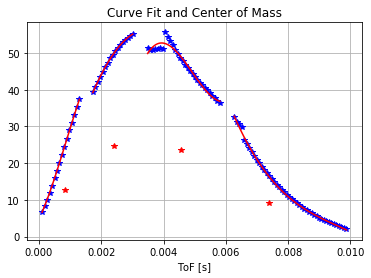

In [9]:
idx_boundaries, boundaries = get_pulse_windows (table_tof,table_shutters)
#idx_boundaries = len(table_tof[tof_name].to_list())
cordX, cordY = get_eff_wavelength (table_tof[tof_name], table_profile[profile_name], idx_boundaries, each_window=False, 
                                   degree_fit = 3, plot_curve = True, weight_triang = [0.1,0.9], weight_top = [1,1], 
                                   zones_percentage = [0.375,0.25])

Plot the curve and the (almost) effective wavelength 

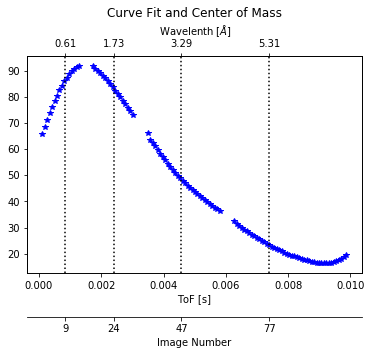

In [10]:
result = pd.concat([table_tof, table_profile], axis=1)
wlt = convert_tof (cordX, flight_path = flight_path, result = 'wavelength')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_title('Curve Fit and Center of Mass')
ax1.plot(result[tof_name], result[profile_name],'b*')
ax1.set_xlabel('ToF [s]')
    
new_tick_locations = cordX
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
conv = [round(elem, 2) for elem in convert_tof(new_tick_locations, flight_path = flight_path, result = 'wavelength') ]
ax2.set_xticklabels(conv)
ax2.set_xlabel(' Wavelenth '+ r'[$\AA$]')

ax3 = ax1.twiny()
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
ax3.spines["bottom"].set_position(("axes", -0.20))

ax3.set_xlim(ax1.get_xlim())
ax3.set_xticks(cordX)
ticks = [(table_tof[tof_name].sub(i).abs().idxmin(axis=1)) for i in cordX]
ax3.set_xticklabels(ticks)
ax3.set_xlabel('Image Number')

for x in cordX:
    plt.axvline(x=x, color='k', linestyle=':')

Set the range for the HE and LE regions

In [26]:
HE_n_LE = [(30,50),(70,90)]

Prepare the folders ypu want to process

In [27]:
trans_imgs_dict = prep_stack_dict(src_dir)
proc_folder01 = [key for key in trans_imgs_dict.keys() if 'batch01' in key]
proc_folder02 = [key for key in trans_imgs_dict.keys() if 'batch02' in key]
proc_folder03 = [key for key in trans_imgs_dict.keys() if 'batch03' in key]

In [28]:
proc_folder01

['004_temp_00_p17_batch01',
 '008_temp_01_p30_batch01',
 '012_temp_02_p40_batch01',
 '016_temp_00_p51_batch01',
 '020_temp_01_p20_batch01',
 '024_temp_02_p5_batch01',
 '028_temp_03_m5_batch01',
 '032_temp_04_m15_batch01']

This will save the relative attenuation images in the given folder

In [29]:
dst = dst_dir + '/batch_01'
trans_imgs_dict = prep_stack_dict(src_dir)
get_relative_att_stack (trans_imgs_dict, dst, HE_n_LE, proc_folder = proc_folder01)

In [30]:
dst = dst_dir + '/batch_02'
trans_imgs_dict = prep_stack_dict(src_dir)
get_relative_att_stack (trans_imgs_dict, dst, HE_n_LE, proc_folder = proc_folder02)

In [31]:
dst = dst_dir + '/batch_03'
trans_imgs_dict = prep_stack_dict(src_dir)
get_relative_att_stack (trans_imgs_dict, dst, HE_n_LE, proc_folder = proc_folder03)